<a href="https://colab.research.google.com/github/shanikairoshi/QML-and-Deep-Unfolded_QML/blob/main/D_QNN_BreastCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit-machine-learning
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 8.3 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512547 sha256=84662304d96ab2abcf28080f0ac8113e09898cd9fcdffd2e6d144f0818c0aaa0
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d

<>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-18-20f44dba53e0>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
  label = 'Malignant' if k is 1 else 'Benign'


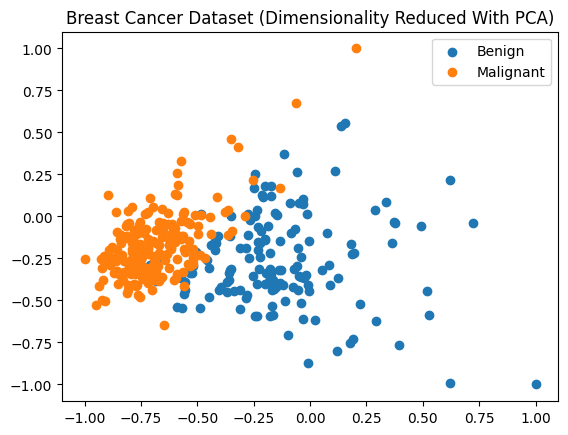

Training data shape: (349, 2)
Testing data shape: (49, 2)


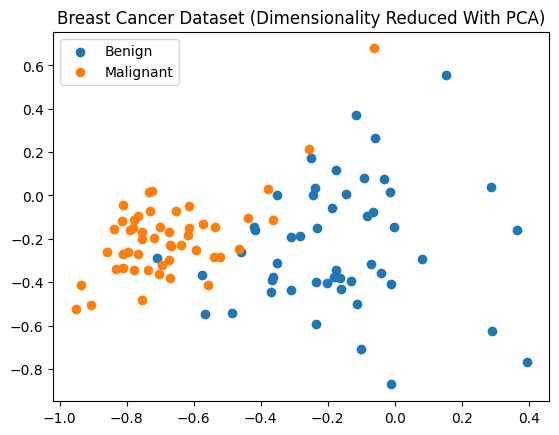

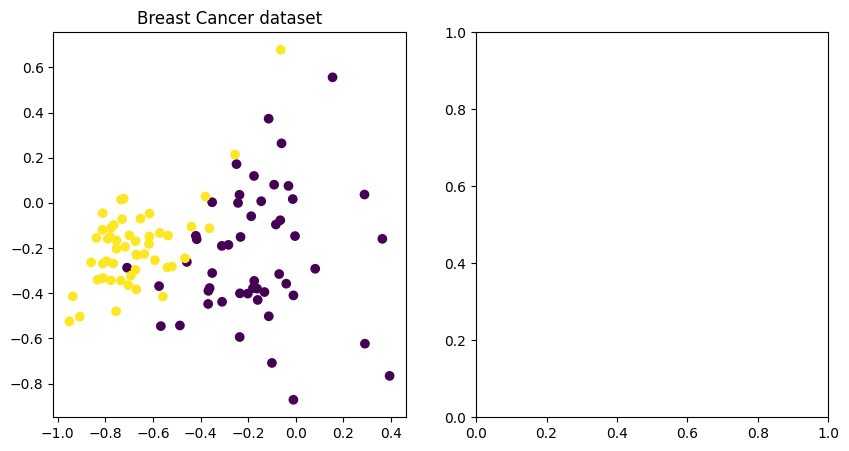

In [18]:
import numpy as np
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


def breast_cancer(training_size, test_size, n, PLOT_DATA=True):
    class_labels = [r'Benign', r'Malignant']

    # First the dataset must be imported.
    cancer = datasets.load_breast_cancer()

    # To find if the classifier is accurate, a common strategy is
    # to divide the dataset into a training set and a test set.
    # Here the data is divided into 70% training, 30% testing.
    X_train, X_test, Y_train, Y_test = train_test_split(cancer.data, cancer.target, test_size=0.3, random_state=109)

    # Now the dataset's features will be standardized
    # to fit a normal distribution.
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # To be able to use this data with the given
    # number of qubits, the data must be broken down from
    # 30 dimensions to `n` dimensions.
    # This is done with Principal Component Analysis (PCA),
    # which finds patterns while keeping variation.
    pca = PCA(n_components=n).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    # The last step in the data processing is
    # to scale the data to be between -1 and 1
    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)

    # Now some sample should be picked to train the model from
    training_input = {key: (X_train[Y_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (X_train[Y_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 2):
            x_axis_data = X_train[Y_train == k, 0][:training_size]
            y_axis_data = X_train[Y_train == k, 1][:training_size]

            label = 'Malignant' if k is 1 else 'Benign'
            plt.scatter(x_axis_data, y_axis_data, label=label)

        plt.title("Breast Cancer Dataset (Dimensionality Reduced With PCA)")
        plt.legend()
        plt.show()


    return X_train, training_input, test_input, class_labels

def split_dataset_to_data_and_labels(input_data):
    data = []
    labels = []
    for label, features in input_data.items():
        data.append(features)
        # Convert labels to 0 and 1
        if label == 'Benign':
            labels.append([0] * len(features))
        else:
            labels.append([1] * len(features))
    return np.vstack(data), np.hstack(labels)

# Set parameters
n = 2  # Number of principal components
training_dataset_size = 200
testing_dataset_size = 100

# Get the dataset and split it
sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

# Split dataset into data and labels
data_train, train_labels = split_dataset_to_data_and_labels(training_input)
data_test, test_labels = split_dataset_to_data_and_labels(test_input)

# Print shapes to verify
print(f"Training data shape: {data_train.shape}")
print(f"Testing data shape: {data_test.shape}")

n = 2 # number of principal components kept
training_dataset_size = 50
testing_dataset_size = 25

sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

data_train, data_train_labels = split_dataset_to_data_and_labels(training_input)
data_test, data_test_labels = split_dataset_to_data_and_labels(test_input)


fig,ax=plt.subplots(1,2,figsize=(10,5))

# Access the data directly from data_train using slicing
ax[0].scatter(data_train[:,0],data_train[:,1],c=data_train_labels) # Use data_train_labels for color coding
ax[0].set_title('Breast Cancer dataset');

D-QNN

Updated code with identified improvements

update the model's parameters incrementally rather than reinitializing them. The learning rate can be updated in between iterations, but the internal model parameters should persist across iterations.

Modifications for Refining Internal Parameters Over Iterations
Persist Weights Across Iterations: Ensure that the model carries over the weights from one iteration to the next instead of resetting them. The NeuralNetworkClassifier should continue training from the existing state.

Avoid Reinitializing the Model: Instead of resetting the model with each fit call, you'll allow the optimizer (SPSA) to continue updating the weights based on the previous state.

Update v3

current version of your code, the learning rate update is based only on the gradient of the objective function and does not take into account the current parameter values (model weights). The learning rate adjustment is applied heuristically, based on the behavior of the objective function gradient (e.g., 0.95 decay if plateauing, 1.05 increase if improving), but it doesn't incorporate the actual state of the model parameters (weights).

<ipython-input-24-e94697de5879>:79: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


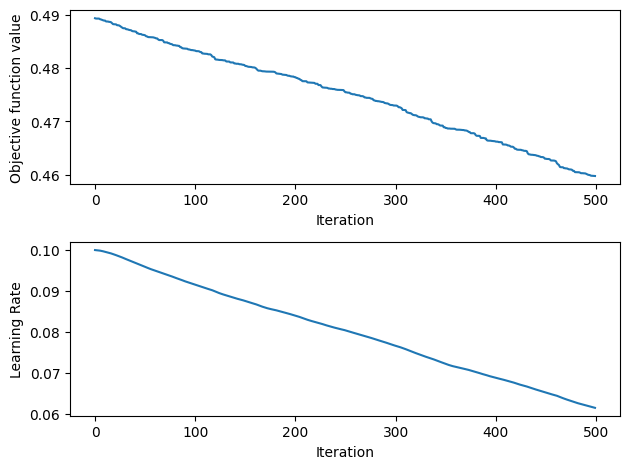

Trained parameters after iteration 10: [ 0.49925093  0.50532554  0.87019407  0.76377063 -0.29337015  0.40902056
  0.65467824  0.4382541  -0.13503864  0.81630639 -0.20080153  0.54824636
  0.16174702  0.60408297  0.34608445  0.11072898  0.31258947  1.0472414
  0.75309931  0.44570682]
Iteration 10 - Training Accuracy: 65.00%
Iteration 10 - Test Accuracy: 45.00%
Final Training Accuracy: 65.00%
Final Test Accuracy: 45.00%
Total Training Time: 1135.85 seconds


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import SPSA
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from IPython.display import clear_output

'''

data_train, data_train_labels = split_dataset_to_data_and_labels(training_input)
data_test, data_test_labels = split_dataset_to_data_and_labels(test_input)
'''


# Split into train and test
#data_train, data_test, data_train_labels, data_test_labels = train_test_split(X, y, test_size=0.2, random_state=42)


# Variables to track objective function and learning rate
objective_func_vals = []
learning_rates = []
initial_learning_rate = 0.1  # Starting learning rate
momentum = 0.9  # Momentum factor for smoother learning rate adjustments
gradient_moving_avg = 0  # Moving average of gradients
initial_params = np.random.rand(RealAmplitudes(data_train.shape[1], reps=4).num_parameters)  # Initialize params

# Define quantum feature map and ansatz
feature_dim = data_train.shape[1]
prep = ZZFeatureMap(feature_dim, reps=2)
ansatz = RealAmplitudes(num_qubits=feature_dim, reps=4)

# Create QNN circuit
qc = QNNCircuit(num_qubits=feature_dim, ansatz=ansatz, feature_map=prep)

# Parity function to interpret QNN output
def parity(x):
    return "{:b}".format(x).count("1") % 2

output_shape = 2

# Define the Sampler QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
)

# Callback for visualization, gradient smoothing, and learning rate adjustment in deep unfolding
def deep_unfolding_learning_rate_adjustment(parameters, obj_func_eval, gradients=None):
    global gradient_moving_avg, learning_rates

    clear_output(wait=True)

    # Save the objective function value for visualization
    objective_func_vals.append(obj_func_eval)

    # If gradients are provided, smooth the gradient using momentum
    if gradients is not None:
        gradient_moving_avg = momentum * gradient_moving_avg + (1 - momentum) * gradients  # Apply moving average
        delta_lr = -0.01 * gradient_moving_avg  # Adjust learning rate based on the smoothed gradient
    else:
        delta_lr = 0  # No gradient info available in this iteration

    if len(learning_rates) > 0:
        new_lr = max(0.0001, learning_rates[-1] + delta_lr)  # Ensure learning rate is positive and non-zero
    else:
        new_lr = initial_learning_rate

    learning_rates.append(new_lr)

    # Visualization of learning rate and objective function
    plt.title("Objective function and Learning Rate")
    plt.subplot(2, 1, 1)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)

    plt.subplot(2, 1, 2)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.plot(range(len(learning_rates)), learning_rates)

    plt.tight_layout()
    plt.show()

# Define the SPSA callback to capture gradients and update learning rate dynamically
def spsa_callback(nfev, parameters, obj_func_eval, stepsize, accept):
    # Assuming `stepsize` contains gradient information or its approximation
    gradients = stepsize
    deep_unfolding_learning_rate_adjustment(parameters, obj_func_eval, gradients)

# Initialize SPSA optimizer with callback
spsa_optimizer = SPSA(maxiter=50, learning_rate=initial_learning_rate, perturbation=0.1, callback=spsa_callback)

# Define the neural network classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    optimizer=spsa_optimizer,
    loss='squared_error',
    initial_point=initial_params,  # Initialize with the starting parameters
)

# Deep Unfolding with multiple iterations
# Continue training with learned weights and adjust learning rate based on performance and gradients.
total_time = 0
current_params = initial_params  # Start with the initial parameters

for i in range(10):  # Deep unfolding iterations
    print(f"Deep Unfolding Iteration {i+1}/10")

    # Train the model with the current parameters
    start_time = time.time()
    sampler_classifier.fit(data_train, data_train_labels)
    end_time = time.time()
    total_time += end_time - start_time

    # After training, retrieve the updated parameters from the optimizer
    # Get the updated parameters from the classifier instead of the optimizer
    current_params = sampler_classifier.weights
    print(f"Trained parameters after iteration {i+1}: {current_params}")

    # Store final weights and learning rate for next round
    final_learning_rate = learning_rates[-1]

    # Evaluate the model performance
    train_accuracy = sampler_classifier.score(data_train, data_train_labels)
    test_accuracy = sampler_classifier.score(data_test, data_test_labels)

    # Log performance
    print(f"Iteration {i+1} - Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Iteration {i+1} - Test Accuracy: {test_accuracy * 100:.2f}%")

    # Update the learning rate for the next iteration based on gradients from SPSA
    spsa_optimizer.learning_rate = learning_rates[-1]
    sampler_classifier.initial_point = current_params

# Print final results
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Total Training Time: {total_time:.2f} seconds")


Updated Learnable parameter code v3


<ipython-input-21-d471da1b0212>:87: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)


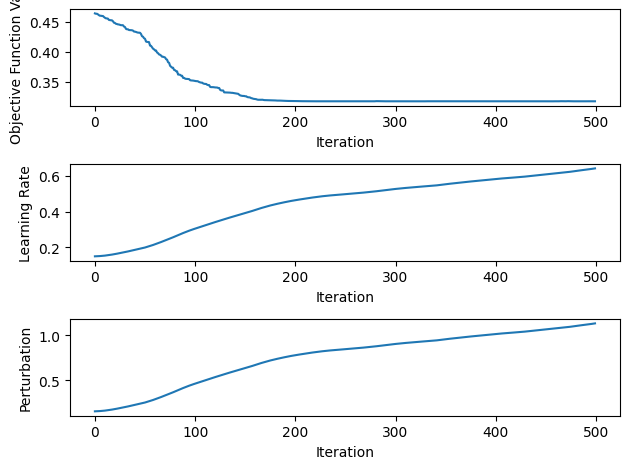

Trained parameters after iteration 10: [-0.75985944  0.32426458  0.85230377 -0.07728054  0.45675416 -1.03134788
 -0.53804669 -0.36494066  0.63485702  0.22246525]
Iteration 10 - Training Accuracy: 86.00%
Iteration 10 - Test Accuracy: 82.00%
Final Training Accuracy: 86.00%
Final Test Accuracy: 82.00%
Total Training Time: 769.41 seconds


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from IPython.display import clear_output
from qiskit_algorithms.optimizers import SPSA

from qiskit_algorithms.utils import algorithm_globals # Import algorithm_globals


# Set random seed for reproducibility using algorithm_globals
algorithm_globals.random_seed = 42  # Set seed globally

# Split into train and test
#data_train, data_test, data_train_labels, data_test_labels = train_test_split(X, y, test_size=0.2, random_state=42)


# Variables to track objective function and learning rate
objective_func_vals = []
learning_rates = []
perturbations = []
initial_learning_rate = 0.15  # Starting learning rate
initial_perturbation = 0.15  # Starting perturbation value
momentum = 0.95  # Momentum factor for smoother learning rate adjustments
gradient_moving_avg = 0  # Moving average of gradients
initial_params = np.random.rand(RealAmplitudes(data_train.shape[1], reps=4).num_parameters)  # Initialize params


# Define quantum feature map and ansatz
feature_dim = data_train.shape[1]
prep = ZZFeatureMap(feature_dim, reps=2)
ansatz = RealAmplitudes(num_qubits=feature_dim, reps=4)

# Create QNN circuit
qc = QNNCircuit(num_qubits=feature_dim, ansatz=ansatz, feature_map=prep)

# Parity function to interpret QNN output
def parity(x):
    return "{:b}".format(x).count("1") % 2

output_shape = 2

# Define the Sampler QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
)

# Callback for visualization, gradient smoothing, and learning rate adjustment in deep unfolding
def deep_unfolding_learning_rate_adjustment(parameters, obj_func_eval, gradients=None):
    global gradient_moving_avg, learning_rates, perturbations

    clear_output(wait=True)

    # Save the objective function value for visualization
    objective_func_vals.append(obj_func_eval)

    # If gradients are provided, smooth the gradient using momentum
    if gradients is not None:
        gradient_moving_avg = momentum * gradient_moving_avg + (1 - momentum) * gradients  # Apply moving average
        delta_lr = 0.05 * gradient_moving_avg  # Adjust learning rate based on the smoothed gradient
        delta_perturbation = 0.1 * gradient_moving_avg  # Adjust perturbation based on the same gradient
    else:
        delta_lr = 0  # No gradient info available in this iteration
        delta_perturbation = 0

    # Update learning rate and perturbation
    if len(learning_rates) > 0:
        new_lr = max(0.001, learning_rates[-1] + delta_lr)  # Ensure learning rate is positive and non-zero
        new_perturbation = max(0.001, perturbations[-1] + delta_perturbation)  # Ensure perturbation is positive
    else:
        new_lr = initial_learning_rate
        new_perturbation = initial_perturbation

    learning_rates.append(new_lr)
    perturbations.append(new_perturbation)

    # Visualization of learning rate and perturbation
    plt.title("Objective Function, Learning Rate, and Perturbation")
    plt.subplot(3, 1, 1)
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)

    plt.subplot(3, 1, 2)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.plot(range(len(learning_rates)), learning_rates)

    plt.subplot(3, 1, 3)
    plt.xlabel("Iteration")
    plt.ylabel("Perturbation")
    plt.plot(range(len(perturbations)), perturbations)

    plt.tight_layout()
    plt.show()

# Define the SPSA callback to capture gradients and update learning rate and perturbation dynamically
def spsa_callback(nfev, parameters, obj_func_eval, stepsize, accept):
    # Assuming `stepsize` contains gradient information or its approximation
    gradients = stepsize
    deep_unfolding_learning_rate_adjustment(parameters, obj_func_eval, gradients)

# Custom SPSA optimizer with learnable learning rate and perturbation
class LearnableLRPerturbationSPSA(SPSA):
    def __init__(self, initial_lr=0.15, initial_perturbation=0.15, lr_alpha=0.01, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = initial_lr  # Initial learning rate
        self.perturbation = initial_perturbation  # Initial perturbation
        self.lr_alpha = lr_alpha  # Learning rate and perturbation update speed

    def _update_learning_rate_and_perturbation(self, gradient, obj_func_eval):
        """
        Update both learning rate and perturbation based on gradient and objective function evaluation.
        The learning rate increases if the objective function improves and decreases otherwise.
        """
        # Use the gradient sign to determine if we should increase or decrease
        grad_lr = np.sign(np.mean(gradient))  # Average gradient sign across parameters

        if grad_lr > 0:  # Objective function is improving
            self.lr += self.lr_alpha * abs(grad_lr)  # Increase learning rate
            self.perturbation += self.lr_alpha * abs(grad_lr)  # Increase perturbation
        else:  # Objective function is getting worse
            self.lr -= self.lr_alpha * abs(grad_lr)  # Decrease learning rate
            self.perturbation -= self.lr_alpha * abs(grad_lr)  # Decrease perturbation

        # Ensure both learning rate and perturbation are positive
        self.lr = max(0.001, self.lr)
        self.perturbation = max(0.001, self.perturbation)

    def step(self, gradient, obj_func_eval):
        """
        Perform optimization step for both parameters, learning rate, and perturbation.
        Use the objective function evaluation to dynamically adjust learning rate and perturbation.
        """
        self._update_learning_rate_and_perturbation(gradient, obj_func_eval)
        return super().step(gradient)  # Perform SPSA step for parameters

# Create optimizer with learnable learning rate and perturbation
spsa_optimizer = LearnableLRPerturbationSPSA(
    maxiter=50, learning_rate=initial_learning_rate, perturbation=initial_perturbation, callback=spsa_callback, lr_alpha=0.01
)

# Define the neural network classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    optimizer=spsa_optimizer,
    loss='squared_error',
    initial_point=initial_params,  # Initialize with the starting parameters
)

import csv
# Prepare to save results in a CSV file
csv_file = "training_results.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Iteration", "Objective Function Value", "Training Accuracy", "Test Accuracy", "Learning Rate", "Perturbation"])

train_accuracies = []
test_accuracies = []

# Deep Unfolding with multiple iterations
# Continue training with learned weights and adjust learning rate based on performance and gradients.
total_time = 0
current_params = initial_params  # Start with the initial parameters

for i in range(10):  # Deep unfolding iterations
    print(f"Deep Unfolding Iteration {i+1}/10")

    # Train the model with the current parameters
    start_time = time.time()
    sampler_classifier.fit(data_train, data_train_labels)
    end_time = time.time()
    total_time += end_time - start_time

    # After training, retrieve the updated parameters from the optimizer
    current_params = sampler_classifier.weights
    print(f"Trained parameters after iteration {i+1}: {current_params}")

    # Store final weights and learning rate for next round
    final_learning_rate = learning_rates[-1]
    final_perturbation = perturbations[-1]

    # Evaluate the model performance
    train_accuracy = sampler_classifier.score(data_train, data_train_labels)
    test_accuracy = sampler_classifier.score(data_test, data_test_labels)

    # Log performance
    print(f"Iteration {i+1} - Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Iteration {i+1} - Test Accuracy: {test_accuracy * 100:.2f}%")

    # Store accuracies for future reference
    # Store accuracies for future reference
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # Write the results to the CSV file
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([i+1, objective_func_vals[-1], train_accuracy * 100, test_accuracy * 100, final_learning_rate, final_perturbation])


    # Update the learning rate for the next iteration based on gradients from SPSA
    spsa_optimizer.learning_rate = learning_rates[-1]
    sampler_classifier.initial_point = current_params

# Print final results
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Total Training Time: {total_time:.2f} seconds")


##QNN

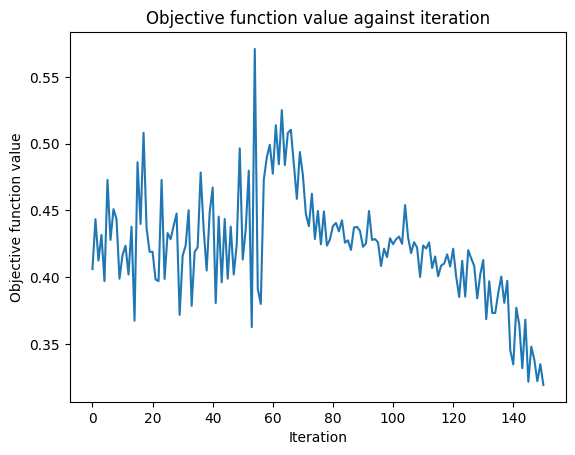

Training Accuracy: 82.00%
Test Accuracy: 80.00%
Total Training Time: 94.06 seconds
Results saved to training_results.csv


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import SPSA

from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from IPython.display import clear_output

from qiskit_algorithms.utils import algorithm_globals # Import algorithm_globals


# Set random seed for reproducibility using algorithm_globals
algorithm_globals.random_seed = 42  # Set seed globally


objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


feature_dim = data_train.shape[1]
prep = ZZFeatureMap(feature_dim, reps=2)
ansatz = RealAmplitudes(num_qubits=feature_dim, reps=4)

qc= QNNCircuit(num_qubits=feature_dim ,ansatz = ansatz, feature_map=prep)
# itr=0
# def training_callback(weights, obj_func_eval):
#         global itr
#         itr += 1
#         print(f"{itr} {obj_func_eval}", end=' | ')
def parity(x):
    return "{:b}".format(x).count("1") % 2
output_shape = 2

sampler_qnn = SamplerQNN(
    circuit = qc,
    interpret=parity,
    output_shape=output_shape,
    # input_gradients= True
)

sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=SPSA(maxiter=50), loss= 'squared_error',callback=callback_graph
)


total_time = 0
start_time = time.time()
sampler_classifier.fit(data_train, data_train_labels)
end_time = time.time()
epoch_time = end_time - start_time
total_time += epoch_time

test_accuracies=[]
train_accuracies=[]
# Evaluate the classifier
train_accuracy = sampler_classifier.score(data_train, data_train_labels)
test_accuracy = sampler_classifier.score(data_test, data_test_labels)

import csv
test_accuracies.append(test_accuracy)
train_accuracies.append(train_accuracy)

# Print the results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Total Training Time: {total_time:.2f} seconds")

# Save the results to a CSV file
csv_file = "training_results.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Iteration", "Objective Function Value", "Training Accuracy", "Test Accuracy"])

    for i in range(len(objective_func_vals)):
        writer.writerow([i+1, objective_func_vals[i], train_accuracies[-1] * 100, test_accuracies[-1] * 100])

print(f"Results saved to {csv_file}")